# ESD 40.317 Financial Systems Design 
## Part 2 Assignment 3

Do not change any of the function definitions or variable names that are given in the cells for you to provide the solution. These function and variable names are used to autograde your solution and changing them might cause the autograder to fail and hence award 0 marks.

Consider the Constant Elasticity of Variance (CEV) model for risk-neutral stock price evolution. It has the following Stochastic Differential Equation (SDE):
$$dx=rxdt+\sigma x^\beta dW$$
The Black Scholes equivalent PDE that arises based on this model is:
$$\frac{1}{2}\sigma^2 x^{2\beta}f_{xx}+rxf_x-rf+f_t=0$$
After the $\tau=T-t$ change of variables as shown in class, the PDE is:
$$\frac{1}{2}\sigma^2 x^{2\beta}f_{xx}+rxf_x-rf=f_\tau$$

In this assignment, you try to price a European KIKO call option with the following terms: 
1. Expiration in 0.5 years
2. Strike price of \\$100
3. Up and in knock-in barrier at \\$115 
4. Up and out knock-out barrier at \\$140   

The term 'KIKO' indicates the presence of both knock-in and knock-out barriers. The option is only activated if the barrier has been knocked-in meaning if the stock price reaches the knock-in barrier. If not, the option is not activated and will not pay out. The knock-out barrier works the opposite way where the option becomes worthless if the stock price reaches the knock-out barrier. The barrier monitoring style for this option is also European, meaning that the check for knocking-in and knocking-out is only performed once, at expiration. 

The other key inputs to the model are as follows:
1. The current stock price, $x_0$ is \\$110
2. Risk free rate, r is 2%
3. Volatility, σ is 25%   

We are interested to find the arbitrage free price of this option based on this model at the current stock price. There are 3 parts to this problem to derive this price using the different FDM techniques you have learned in class. Each part has the function definition required in the cell which will return V, the array corresponding to the option prices and xs, the array corresponding to the points in x representing the stock price. For each part, you are to store these two arrays in the defined variables e.g. for the 2nd part, the results are stored in V2, xs2. 

**These function and variable definitions will be used to assess the solution and will also be used in the final plot.** The arguments that the function uses are the same as in the in class exercises except for the additional barriers defined as KI and KO.

Run the cell below to import the packages and define the inputs required.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Input parameters
X0 = 110.     # initial stock price
σ = 0.25      # volatility
r = 0.02      # risk free rate
K = 100       # strike price
KI = 115      # knock in barrier
KO = 125      # knock out barrier
T = 0.5       # time to maturity
β = 0.75      # beta for the CEV model
m = 2         # multiplier for the strike price to define boundary of the x axis

### a) Explicit FDM

Solve the PDE with the initial boundary conditions using the Explicit FDM with the number of steps for the asset price as an input and determine the minimum number of time steps to maintain the stability condition within the algorithm. Experiment with **Nx** to see what is the lowest number required to get the option value at $x_0$ as a percentage of $x_0$ to be within 1 basis point (0.01%) of  4.01% i.e. $\frac{option value}{110}\approx 4.01\% \pm 0.01\%$ by running the autograding cells. 

Note: In the industry, prices are typically quoted as a percentage of the notional where notional is the spot price times the number of options. This makes it convenient to quote a single price that can be used for different notional sizes rather than quoting a \\$ price that changes depending on the number of options.

Hint: Nx will be a large number well in excess of 1000.

(25 marks)

In [2]:
def Explicit_FDM_CEV(σ, r, K, KI, KO, T, Nx, β, m=2):
    # ADD CODE HERE
    xs = np.linspace(0, m*K, Nx+1) 
    Δx = xs[1]-xs[0]
    # get the minimum value 
    Δt = 0.9/Nx**2/σ**2 # ADD CODE HERE    
    Nt = int(T/Δt) # ensure that Nt is an integer for the time loop
    
    # initial condition of option
    V = np.maximum(xs-K, 0)
    KI_index = np.where(xs < KI)
    KO_index = np.where(xs >= KO)
    V[KI_index[0]] = 0
    V[KO_index[0]] = 0
    
    # Set up matrix diagonals
    d0 = 1 - σ**2 * np.power(xs,2*β)*Δt/Δx**2 - r*Δt
    d1 = 0.5*(r*xs[0:-1]*Δt/Δx + σ**2 *np.power(xs[0:-1],2*β)*Δt/Δx**2) # ADD CODE HERE
    dm1 = 0.5*(σ**2 * np.power(xs[1:],2*β)*Δt/Δx**2 - r*xs[1:]*Δt/Δx) # ADD CODE HERE 
    
    # Boundary condition for small asset price
    d0[0] = (1 - r * Δt) # ADD CODE HERE 
    d1[0] = 0 # ADD CODE HERE 
    
    # Construct the matrix
    A = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    
    for t in range(Nt):
        V = A.dot(V)
        # Boundary condition for large asset price
        # ADD CODE HERE
        V[-1] = 2.*V[-2] - V[-3]
    
    
    return V, xs

# ADD CODE HERE
Nx = 5200
print(Nx)
V1, xs1 = Explicit_FDM_CEV(σ, r, K, KI, KO, T, Nx, β, m)
print("test 1: ", len(V1) == len(xs1))
print("test 2:", xs1[0] == 0)

dx1 = xs1[1] - xs1[0]
idx1 = X0 / dx1
if idx1.is_integer():
    if math.fabs(V1[int(idx1)] / X0 - 0.0401) < 1e-4:
        print("value: ", math.fabs(V1[int(idx1)] / X0 - 0.0401))
        print("test 3:", "pass")
    else:
        print("test 3:", "fail")
else:
    diff1 = V1[int(idx1) + 1] - V1[int(idx1)]
    interpolation1 = V1[int(idx1)] + (idx1 - int(idx1)) * diff1
    print("value: ", math.fabs(interpolation1 / X0 - 0.0401))
    print("test 4: ", math.fabs(interpolation1 / X0 - 0.0401) < 1e-4)

5200
test 1:  True
test 2: True
value:  9.879236697760835e-05
test 3: pass


In [3]:
%%time

V1, xs1 = Explicit_FDM_CEV(σ, r, K, KI, KO, T, Nx, β, m)

assert len(V1) == len(xs1)
assert xs1[0] == 0

Wall time: 16.3 s


In [4]:
dx1 = xs1[1] - xs1[0]
idx1 = X0 / dx1

if idx1.is_integer():
    print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.5%}'.format(X0, V1[int(idx1)] / X0))
    assert math.fabs(V1[int(idx1)] / X0 - 0.0401) < 1e-4
else:
    diff1 = V1[int(idx1) + 1] - V1[int(idx1)]
    interpolation1 = V1[int(idx1)] + (idx1 - int(idx1)) * diff1
    print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.5%}'.format(X0, interpolation1 / X0))
    assert math.fabs(interpolation1 / X0 - 0.0401) < 1e-4

Option price as a percentage of spot at x0 = 110 is 4.01988%


### b) Crank Nicolson

Solve the PDE with Crank Nicolson using **Nt** = 500. Experiment with **Nx** to see what is the lowest number required to get the option value at $x_0$ as a percentage of $x_0$ to be within 1 basis point (0.01%) of  4.01% i.e. $\frac{option value}{110}\approx 4.01\% \pm 0.01\%$ by running the autograding cells.  

Hint: Nx will be a large number well in excess of 1000.

(25 marks)

In [33]:
def Crank_Nicolson_FDM_CEV(σ, r, K, KI, KO, T, Nx, Nt, β, m=2):
    # ADD CODE HERE
    
    xs = np.linspace(0, m*K, Nx+1) 
    Δx = xs[1]-xs[0]
    Δt = T / Nt 
    
    # initial condition of option
    V = np.maximum(xs-K, 0)
    KI_index = np.where(xs < KI)
    KO_index = np.where(xs >= KO)
    V[KI_index[0]] = 0
    V[KO_index[0]] = 0

    # Set up RHS matrix diagonals
    d0 = 1 - 0.5*(σ**2 * np.power(xs,2*β)*Δt/Δx**2 + r*Δt) # ADD CODE HERE
    d1 = 0.5*0.5*(r*xs[0:-1]*Δt/Δx + σ**2 *np.power(xs[0:-1],2*β)*Δt/Δx**2) # ADD CODE HERE
    dm1 = 0.5*0.5*(σ**2 * np.power(xs[1:],2*β)*Δt/Δx**2 - r*xs[1:]*Δt/Δx) # ADD CODE HERE
    
    # Boundary condition for small asset price
    d0[0] = 1
    d1[0] = 0
    
    # Boundary condition for large asset price
    d0[-1] = 0 # ADD CODE HERE
    dm1[-1] = 0 # ADD CODE HERE
    
    # Construct RHS matrix
    B = diags([dm1,d0,d1], [-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)

    # Set up LHS matrix diagonals
    d0 = 2-d0 # ADD CODE HERE
    d1 = -d1 # ADD CODE HERE
    dm1 = -dm1 # ADD CODE HERE
    dm2 = np.zeros(Nx-1)
    
    # Boundary condition for small asset price
    d0[0] = 1/(1 - r * Δt) # ADD CODE HERE
    d1[0] = 0 # ADD CODE HERE
    
    # Boundary condition for large asset price
    d0[-1] = 1
    dm1[-1] = -2
    dm2[-1] = 1

    # Construct LHS matrix
    A = diags([dm2,dm1,d0,d1], [-2,-1, 0, 1], shape=(Nx+1,Nx+1), dtype=float)
    A = A.tocsr()
    
    for t in range(Nt):
        V = B.dot(V)
        V = spsolve(A,V)
    
    return V, xs

Nt = 500
# ADD CODE HERE

V2, xs2 = Crank_Nicolson_FDM_CEV(σ, r, K, KI, KO, T, Nx, Nt, β, m)
test1 = len(V2) == len(xs2)
test2 = xs2[0] == 0
print('test 1:', test1)
print('test 2:', test2)
dx2 = xs2[1] - xs2[0]
idx2 = X0 / dx2
if idx2.is_integer():
    print(math.fabs(V2[int(idx2)] / X0 - 0.0401))
    print("test 3:", math.fabs(V2[int(idx2)] / X0 - 0.0401) < 1e-4)
else:
    diff2 = V2[int(idx2) + 1] - V2[int(idx2)]
    interpolation2 = V2[int(idx2)] + (idx2 - int(idx2)) * diff2
    print(math.fabs(interpolation2 / X0 - 0.0401))
    print("test 4:", math.fabs(interpolation2 / X0 - 0.0401) < 1e-4)
print((np.abs(V1 - V2) < 1e-4).all())

test 1: True
test 2: True
9.881193608905076e-05
test 3: True
True


In [34]:
%%time 

V2, xs2 = Crank_Nicolson_FDM_CEV(σ, r, K, KI, KO, T, Nx, Nt, β, m)

assert len(V2) == len(xs2)
assert xs2[0] == 0

Wall time: 1.11 s


In [35]:
dx2 = xs2[1] - xs2[0]
idx2 = X0 / dx2
if idx2.is_integer():
    print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.5%}'.format(X0, V2[int(idx2)] / X0))
    assert math.fabs(V2[int(idx2)] / X0 - 0.0401) < 1e-4
else:
    diff2 = V2[int(idx2) + 1] - V2[int(idx2)]
    interpolation2 = V2[int(idx2)] + (idx2 - int(idx2)) * diff2
    print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.5%}'.format(X0, interpolation2 / X0))
    assert math.fabs(interpolation2 / X0 - 0.0401) < 1e-4

Option price as a percentage of spot at x0 = 110 is 4.01988%


### c) Richardson Extrapolation

Solve the PDE with using Richardson Extrapolation on Crank Nicolson using **Nt** = 250. The function should execute two runs of teh Crank Nicolson algorithm defined above. The first run will use **Nx** and **Nt** given in the argument. The second run should double **Nx** i.e. scale $\Delta x$ down by half. Determine what is the appropriate value for **Nt** for this run and then perform Richardson Extrapolation on the values returned by both runs. 

The final Richardson Extrapolated price vector will be returned as **V**. The function will return both of the **xs** variables. **xs_run1** is for the first run while **xs_run2** is for the second run. The number of time steps for the first run and second run will also be returned in **Nt_run1** and **Nt_run2**. This is used  

Experiment with **Nx** to see what is the lowest number required to get the option value at $x_0$ as a percentage of $x_0$ to be within 1 basis point (0.01%) of  4.01% i.e. $\frac{option value}{110}\approx 4.01\% \pm 0.01\%$ by running the autograding cells.

Hint: Nx will be a large number well in excess of 1000.

(50 marks)

In [36]:
def Richardson(σ, r, K, KI, KO, T, Nx, Nt, β, m=2):
    # ADD CODE HERE
    
    Nt_run1 = Nt
    V_run1, xs_run1 = Crank_Nicolson_FDM_CEV(σ, r, K, KI, KO, T, Nx, Nt_run1, β, m=2)
    Δx_run1 = xs_run1[1]-xs_run1[0]
    
    # multiply Nt by 2 as Nx is multiplied by 2
    Nt_run2 = 2*Nt
    V_run2, xs_run2 = Crank_Nicolson_FDM_CEV(σ, r, K, KI, KO, T, 2*Nx, Nt_run2, β, m=2)
    Δx_run2 = xs_run2[1]-xs_run2[0]
    
    # calculate V
    V = (np.multiply(Δx_run2**2,V_run1) - np.multiply(Δx_run1**2,V_run2[::2])) / (Δx_run2**2 - Δx_run1**2)
    
    return V, xs_run1, xs_run2, Nt_run1, Nt_run2

Nt=250
# ADD CODE HERE

In [37]:
%%time 

V3, xs3, xs3b, Nt1, Nt2 = Richardson(σ, r, K, KI, KO, T, Nx, Nt, β, m)

assert len(V3) == len(xs3)
assert xs3[0] == 0

Wall time: 2.38 s


In [38]:
dx3 = xs3[1] - xs3[0]
idx3 = X0 / dx3
if idx3.is_integer():
    print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.5%}'.format(X0, V3[int(idx3)] / X0))
    assert math.fabs(V3[int(idx3)] / X0 - 0.0401) < 1e-4
else:
    diff3 = V3[int(idx3) + 1] - V3[int(idx3)]
    interpolation3 = V3[int(idx3)] + (idx3 - int(idx3)) * diff3
    print('Option price as a percentage of spot at x0 = {0:.0f} is {1:.5%}'.format(X0, interpolation3 / X0))
    assert math.fabs(interpolation3 / X0 - 0.0401) < 1e-4

Option price as a percentage of spot at x0 = 110 is 4.01244%


Run the cell below which will plot all 3 outputs and the lines should overlap.

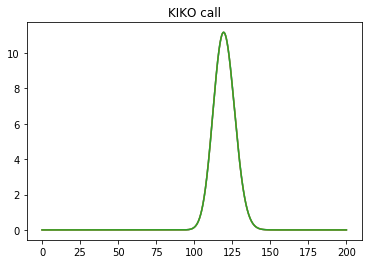

In [39]:
%matplotlib inline

plt.plot(xs1, V1, xs2, V2, xs3, V3)
plt.title("KIKO call");